In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from formulae import design_matrices

sns.set()

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
games = pd.read_parquet(Path("../data/iowa_games.parquet"))

In [4]:
games.describe()

,id,season,week,attendance,venue_id,home_id,home_points,home_post_win_prob,home_pregame_elo,home_postgame_elo,away_id,away_points,away_post_win_prob,away_pregame_elo,away_postgame_elo,excitement_index
count,8.100000e+01,81.000000,81.000000,72.000000,81.000000,81.000000,73.000000,73.000000,80.00000,72.000000,81.000000,73.000000,73.000000,79.000000,71.000000,73.000000
mean,4.012164e+08,2020.012346,7.604938,59169.805556,3672.641975,1488.641975,22.958904,0.619437,1702.63750,1720.902778,1412.802469,19.328767,0.380563,1666.873418,1674.281690,4.588492
std,1.995202e+05,2.052400,4.088640,24701.039025,826.382059,1047.931228,12.414640,0.398693,170.03516,182.855454,1086.824128,13.704272,0.398693,199.652992,212.183491,2.325102
min,4.009345e+08,2017.000000,1.000000,771.000000,347.000000,66.000000,0.000000,0.000813,1243.00000,1125.000000,36.000000,0.000000,0.000007,1208.000000,1208.000000,0.369269
25%,4.010129e+08,2018.000000,4.000000,57027.500000,3793.000000,194.000000,14.000000,0.134614,1627.75000,1627.750000,164.000000,10.000000,0.014219,1508.000000,1504.500000,2.751047
50%,4.012473e+08,2020.000000,8.000000,66838.000000,3793.000000,2294.000000,23.000000,0.800132,1704.00000,1737.000000,2294.000000,18.000000,0.199868,1660.000000,1700.000000,4.269377
75%,4.014051e+08,2022.000000,11.000000,69250.000000,3830.000000,2294.000000,31.000000,0.985781,1810.00000,1844.250000,2294.000000,24.000000,0.865386,1829.000000,1833.000000,6.770252
max,4.015204e+08,2023.000000,15.000000,111519.000000,6577.000000,2509.000000,55.000000,0.999993,2165.00000,2233.000000,2751.000000,63.000000,0.999187,2161.000000,2065.000000,9.467260


In [5]:
def get_iowa_points(game):
    if game.away_team == "Iowa":
        return game.away_points
    else:
        return game.home_points


iowa_points = games.apply(get_iowa_points, axis="columns").dropna()
games["Iowa_points"] = iowa_points
games["Home_game"] = games["home_team"] == "Iowa"
games["Years_since_2017"] = games["season"] - 2017

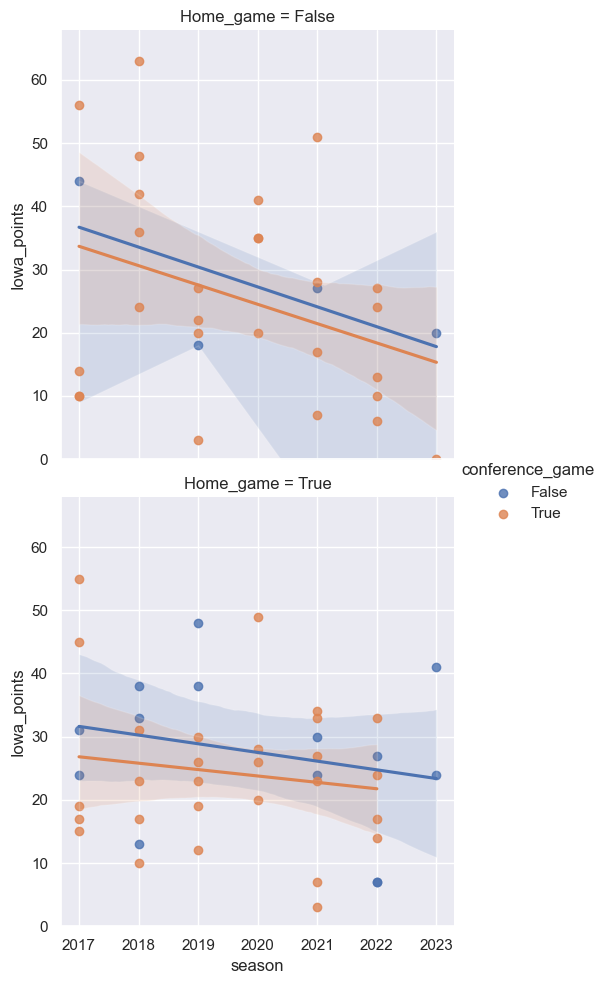

In [6]:
g = sns.lmplot(
    games,
    x="season",
    y="Iowa_points",
    hue="conference_game",
    row="Home_game",
)
g.set(ylim=(0, None))

In [7]:
games.pivot_table(
    "Iowa_points",
    "conference_game",
    "Home_game",
)

Home_game,False,True
conference_game,,
False,27.250000,27.500000
True,25.518519,24.285714


# Bayesian mixed-effects model

Let's predict scoring from 2019 on...


In [8]:
design_matrix = design_matrices(
    "Iowa_points ~ conference_game * Home_game",
    games.query("season>2018"),
)
exogenous = design_matrix.common.as_dataframe()
endogenous = design_matrix.response.as_dataframe()

Automatically removing 8/57 rows from the dataset.


In [9]:
with pm.Model() as model:
    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=26, sigma=10)
    b1 = pm.Normal("conference_game", mu=0, sigma=10)
    b2 = pm.Normal("Home_game", mu=0, sigma=10)
    b3 = pm.Normal("conference_game:Home_game", mu=0, sigma=10)

    # define linear model and link function
    theta = (
        b0
        + b1 * exogenous["conference_game"].values
        + b2 * exogenous["Home_game"].values
        + b3 * exogenous["conference_game:Home_game"].values
    )

    # Define Poisson likelihood
    y = pm.Poisson(
        "y", mu=pm.math.exp(theta), observed=endogenous["Iowa_points"].values
    )

    # sample
    points = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, conference_game, Home_game, conference_game:Home_game]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


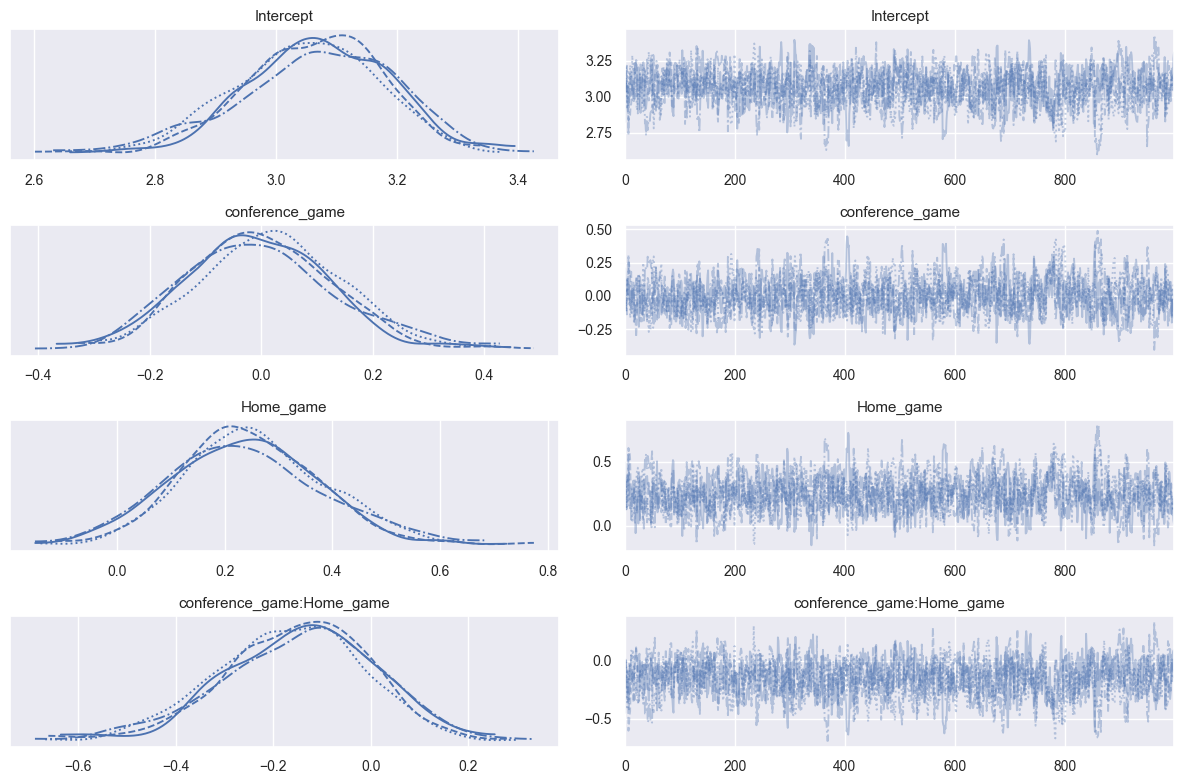

In [10]:
az.plot_trace(points)
plt.tight_layout()

Okay, back in cartesian space, what's the average scoring?


In [11]:
az.summary(np.exp(points.posterior["Intercept"]), kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,21.516,2.586,16.543,26.074


Now, given 9 games left (including the bowl), these being conference games, and 5 of them being at home, what is the chance of Brian getting to stay?

He's got to score at least 27 per game now to keep the 25 per game average.


In [12]:
p = points.posterior

posterior_2023_points = np.exp(
    (p["Intercept"] + p["conference_game"] + (5 / 9) * p["Home_game"]).data.ravel()
)
# plt.hist(posterior_2023_points, bins=np.arange(15, 35), cumulative=True, align="left")
# np.percentile(posterior_2023_points, 90)
print("Chance of Brian staying:", np.mean(posterior_2023_points >= 27))

Chance of Brian staying: 0.14575


That's not good. Let's make a plot to look at the distribution


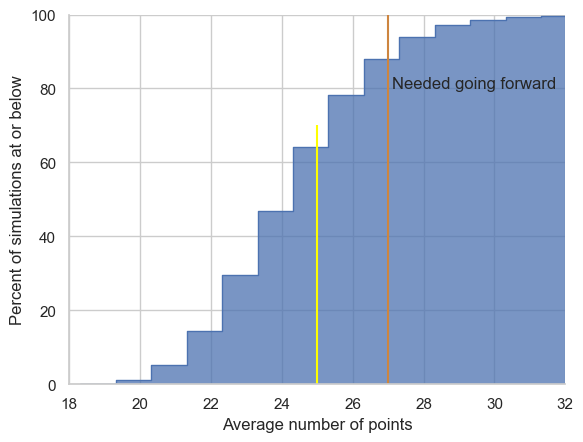

In [13]:
with sns.axes_style("whitegrid"):
    g = sns.histplot(
        posterior_2023_points,
        discrete=True,
        element="step",
        stat="percent",
        cumulative=True,
    )
    g.set(
        xlim=(18, 32),
        ylim=(0, 100),
        ylabel="Percent of simulations at or below",
        xlabel="Average number of points",
    )
    g.vlines(27, 0, 100, color="peru")
    g.vlines(25, 0, 70, color="yellow")
    sns.despine()
    g.annotate("Needed going forward", xy=(27.1, 80))